# Evaluate all the cross terms

### Canonic momentum

Read the simulation data

In [1]:
# We create a list with the files to read

Nevs = 100; Nc = 3

file_list = [['/lustre/HQCD/carlos.lamas/qJetLFH_vQM/output/comp_results/result_{%i}_OUTPUT_VGlasma_nophase_R_q_g_1.000_WF_Init_q_Gaussian_nPx0_nPy0_wx_10.000000_wy_10.000000_cQ_%i_hQ_1_mq0_0.100_mq_0.100_mg_0.150_Lperp_2_Nperp_64_Leta_2.500000_Neta_1_Lmin_10.00_Kmax_2_g2mu_0.000_onMPIrank_0_step_32/pperp/evolution_Pperp_sq.dat' %(nev, nc) for nev in range(Nevs)] for nc in range(1, Nc+1)]

In [2]:
# We convert to an array of DataFrames

import pandas as pd 
import numpy as np

df_list = []

for i in range(Nevs):
    df = [pd.read_table(file_list[c][i], header = None) for c in range(Nc)]
    df_list.append(df)

data = np.array(df_list)

print(np.shape(data))

(100, 3, 33, 4)


In [3]:
# Average over quark color and events

data_av_col = np.average(data, axis=1)
data_av_ev = np.average(data_av_col, axis=0)

In [4]:
# Extract the results

xplus = data_av_ev[:, 0]
py2 = data_av_ev[:, 2]
pz2 = data_av_ev[:, 1]

Compute momentum broadening as $<(\delta p)^2> = <p^2> - <p_0^2>$

In [5]:
py2 -= py2[0]
pz2 -= pz2[0]

We plot the results

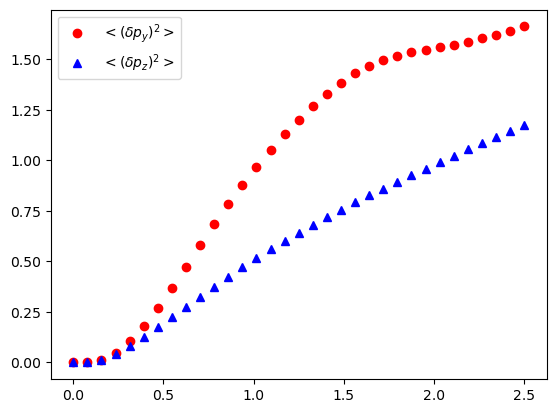

In [6]:
import matplotlib.pyplot as plt

plt.plot(xplus, py2, 'ro', label=r'$<(\delta p_y)^2>$')
plt.plot(xplus, pz2, 'b^', label=r'$<(\delta p_z)^2>$')

plt.legend()

plt.savefig('GoodResults_data/CanonicMomentum.png', bbox_inches='tight')

### Transverse field contribution

Let us use the fields obtained from the Glasma code to compute the field contribution

In [17]:
import numpy as np

Ay_data_list = []; Az_data_list = []

Nevs = 100 # Number of events

for i in range(Nevs):
    
    Ay_filename = f'/lustre/HQCD/carlos.lamas/curraun/simulations/comp_by_comp/fields_for_trace/Ay_tr_{i}.npy'
    Ay_data = np.load(Ay_filename)
    Ay_data_list.append(Ay_data)
    
    Az_filename = f'/lustre/HQCD/carlos.lamas/curraun/simulations/comp_by_comp/fields_for_trace/Az_tr_{i}.npy'
    Az_data = np.load(Az_filename)
    Az_data_list.append(Az_data)

Ay_data = np.array(Ay_data_list)
Az_data = np.array(Az_data_list)

print(Ay_data.shape, Az_data.shape)

(100, 32, 3, 3) (100, 32, 3, 3)


In [24]:
# Compute the contribution for every event

pAy2 = np.zeros((Nevs, Ay_data.shape[1]))
pAz2 = np.zeros((Nevs, Az_data.shape[1]))

for n in range(Nevs):
    for xp in range(Ay_data.shape[1]):
        Ay2 = np.trace(Ay_data[n, xp] @ Ay_data[n, xp]).real
        Az2 = np.trace(Az_data[n, xp] @ Az_data[n, xp]).real
        
        Ay2_0 = np.trace(Ay_data[n, 0] @ Ay_data[n, 0]).real
        Az2_0 = np.trace(Az_data[n, 0] @ Az_data[n, 0]).real
        
        AyAy0 = np.trace(Ay_data[n, xp] @ Ay_data[n, 0]).real
        AzAz0 = np.trace(Az_data[n, xp] @ Az_data[n, 0]).real
        
        pAy2[n, xp] = 1/3*(Ay2 + Ay2_0 - 2*AyAy0)
        pAz2[n, xp] = 1/3*(Az2 + Az2_0 - 2*AzAz0)
        
        

In [25]:
# Average over events
pAy2_av = np.average(pAy2, axis=0)
pAz2_av = np.average(pAz2, axis=0)

Plot the results

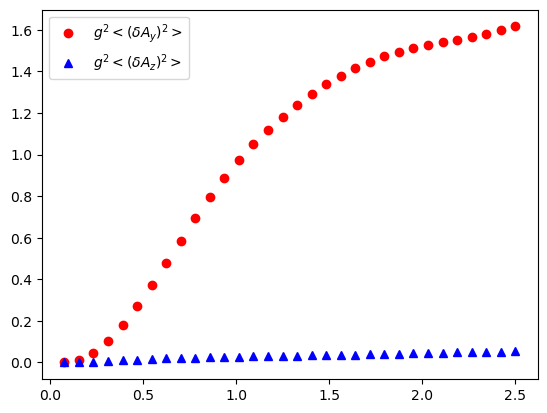

In [27]:
import matplotlib.pyplot as plt

# For y component

plt.plot(xplus[1:], pAy2_av, 'ro', label=r'$g^2<(\delta A_y)^2>$')
plt.plot(xplus[1:], pAz2_av, 'b^', label=r'$g^2<(\delta A_z)^2>$')

plt.legend()

plt.savefig('GoodResults_data/FieldContribution.png', bbox_inches='tight')

### Cross term

In [11]:
py2_cross = data[:, :, :, 2]
pz2_cross = data[:, :, :, 1]

pyAy = np.zeros((Nevs, Nc, Ay_data.shape[1]))
pzAz = np.zeros((Nevs, Nc, Az_data.shape[1]))

for n in range(Nevs):
    for c in range(Nc):
        py_aux = py2_cross[n, c, 1:] - py2_cross[n, c, 0]
        pz_aux = pz2_cross[n, c, 1:] - pz2_cross[n, c, 0]
        
        pyAy[n, c] = abs(py_aux * Ay_data[n, :, c, c].real)
        pzAz[n, c] = abs(pz_aux * Az_data[n, :, c, c].real)

In [12]:
pyAy_av = np.average(pyAy, axis=(0, 1))
pzAz_av = np.average(pzAz, axis=(0, 1))

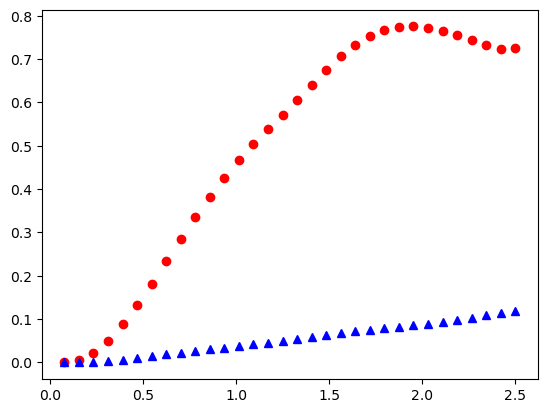

In [13]:
# Plot the cross term

plt.plot(xplus[1:],pyAy_av, 'ro', label=r'$<(\delta p_y)^2>$')
plt.plot(xplus[1:], pzAz_av, 'b^', label=r'$<(\delta p_z)^2>$')

All together

In [14]:
pkin_y2 = py2[1:] + pAy2_av - 2*pyAy_av
pkin_z2 = pz2[1:] + pAz2_av - 2*pzAz_av

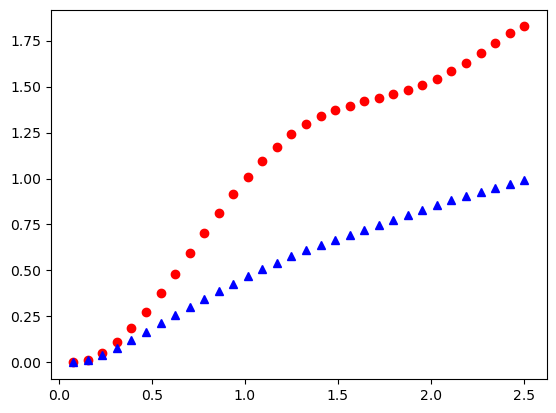

In [15]:
import matplotlib.pyplot as plt

plt.plot(xplus[1:], pkin_y2, 'ro', label=r'$<(\delta p_y)_{kin}>^2$')
plt.plot(xplus[1:], pkin_z2, 'b^', label=r'$<(\delta p_z)_{kin}>^2$')

### Cross term

In [15]:
file_list = [['/lustre/HQCD/carlos.lamas/qJetLFH_vQM/output/comp_results/result_{%i}_OUTPUT_VGlasma_nophase_R_q_g_1.000_WF_Init_q_Gaussian_nPx0_nPy0_wx_10.000000_wy_10.000000_cQ_%i_hQ_1_mq0_0.100_mq_0.100_mg_0.150_Lperp_2_Nperp_64_Leta_2.500000_Neta_1_Lmin_10.00_Kmax_2_g2mu_0.000_onMPIrank_0_step_32/PIperp/evolution_Piperp_sq_exp_autonomy.dat' %(nev, nc) for nev in range(Nevs)] for nc in range(1, Nc+1)]

In [16]:
# We convert to an array of DataFrames

import pandas as pd 
import numpy as np

df_list = []

for i in range(Nevs):
    df = [pd.read_table(file_list[c][i], header = None) for c in range(Nc)]
    df_list.append(df)

data = np.array(df_list)

print(np.shape(data))

(100, 3, 33, 9)


In [17]:
# Average over quark color and events

data_av_col = np.average(data, axis=1)
data_av_ev = np.average(data_av_col, axis=0)

In [18]:
# Extract the results

xplus = data_av_ev[:, 0]
pyAy = data_av_ev[:, 7]
pzAz = data_av_ev[:, 3]

We plot the results

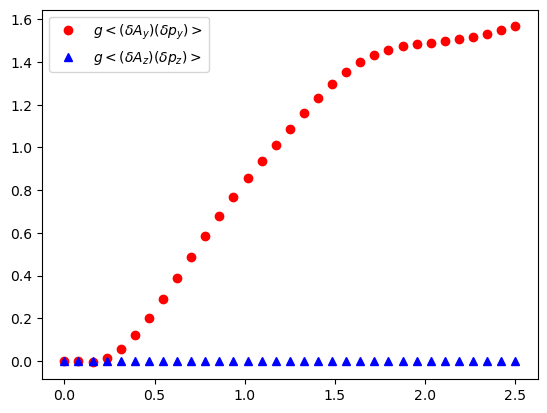

In [19]:
import matplotlib.pyplot as plt

# For y component

plt.plot(xplus, pyAy, 'ro', label=r'$g<(\delta A_y)(\delta p_y)>$')
plt.plot(xplus, pzAz, 'b^', label=r'$g<(\delta A_z)(\delta p_z)>$')

plt.legend()

plt.savefig('GoodResults_data/FieldContribution.png', bbox_inches='tight')

### Final calculation

Get canonic broadening

In [1]:
# We create a list with the files to read

Nevs = 100; Nc = 3

file_list = [['/lustre/HQCD/carlos.lamas/qJetLFH_vQM/output/sub_A0_v2/result_{%i}_OUTPUT_VGlasma_nophase_R_q_g_1.000_WF_Init_q_Gaussian_nPx0_nPy0_wx_10.000000_wy_10.000000_cQ_%i_hQ_1_mq0_0.100_mq_0.100_mg_0.150_Lperp_2_Nperp_64_Leta_2.500000_Neta_1_Lmin_10.00_Kmax_2_g2mu_0.000_onMPIrank_0_step_32/pperp/evolution_Pperp_sq.dat' %(nev, nc) for nev in range(Nevs)] for nc in range(1, Nc+1)]

In [2]:
# We convert to an array of DataFrames

import pandas as pd 
import numpy as np

df_list = []

for i in range(Nevs):
    df = [pd.read_table(file_list[c][i], header = None) for c in range(Nc)]
    df_list.append(df)

data = np.array(df_list)

print(np.shape(data))

(100, 3, 33, 4)


In [3]:
xplus = data[0, 0, :, 0]

py = np.zeros((Nevs, Nc, data.shape[2]))
pz = np.zeros((Nevs, Nc, data.shape[2]))

for n in range(Nevs):
    for c in range(Nc):
        py2 = data[n, c, :, 2]
        pz2 = data[n, c, :, 1]
        
        py2 -= py2[0]
        pz2 -= pz2[0]
        
        py[n, c, :] = np.sqrt(py2)
        pz[n, c, :] = np.sqrt(pz2)

Subtract the transverse field

In [4]:
import numpy as np

Ay_data_list = []; Az_data_list = []

Nevs = 100 # Number of events

for i in range(Nevs):
    
    Ay_filename = f'/lustre/HQCD/carlos.lamas/curraun/simulations/sub_A0_v2/sub_A0_fields_for_trace/Ay_tr_{i}.npy'
    Ay_data = np.load(Ay_filename)
    Ay_data_list.append(Ay_data)
    
    Az_filename = f'/lustre/HQCD/carlos.lamas/curraun/simulations/sub_A0_v2/sub_A0_fields_for_trace/Ay_tr_{i}.npy'
    Az_data = np.load(Az_filename)
    Az_data_list.append(Az_data)

Ay_dat = np.array(Ay_data_list)
Az_dat = np.array(Az_data_list)

print(Ay_dat.shape, Az_dat.shape)

(100, 32, 3, 3) (100, 32, 3, 3)


In [5]:
Ay2 = np.zeros((Nevs, Nc, Ay_dat.shape[1]))
Az2 = np.zeros((Nevs, Nc, Az_dat.shape[1]))

for n in range(Nevs):
    for xp in range(Ay_dat.shape[1]):
        aux_y = Ay_dat[n, xp] @ Ay_dat[n, xp]
        aux_z = Az_dat[n, xp] @ Az_dat[n, xp]
        
        for c in range(Nc):
            Ay2[n, c, xp] = aux_y[c, c].real
            Az2[n, c, xp] = aux_z[c, c].real


In [8]:
pkin_y2 = np.zeros((Nevs, Nc, Ay_dat.shape[1]))
pkin_z2 = np.zeros((Nevs, Nc, Az_dat.shape[1]))

for n in range(Nevs):
    for c in range(Nc):
        Ay = np.sqrt(Ay2[n, c, :])
        Az = np.sqrt(Az2[n, c, :])
        
        pkin_y = py[n, c, 1:] - Ay
        pkin_z = pz[n, c, 1:] - Az
        
        pkin_y2[n, c] = pkin_y**2
        pkin_z2[n, c] = pkin_z**2

In [9]:
# Average over events

pkin_y2_av_col = np.average(pkin_y2, axis=(1))
pkin_z2_av_col = np.average(pkin_z2, axis=(1))

pkin_y2_av = np.average(pkin_y2_av_col, axis=0)
pkin_z2_av = np.average(pkin_z2_av_col, axis=0)

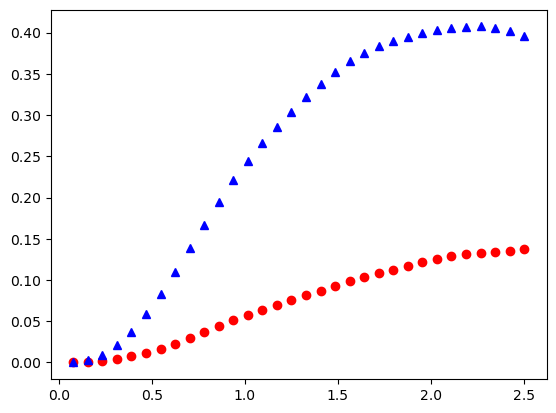

In [10]:
# We plot the results

import matplotlib.pyplot as plt

plt.plot(xplus[1:], pkin_y2_av, 'ro', label=r'$<(\delta p_y)^2>$')
plt.plot(xplus[1:], pkin_z2_av, 'b^', label=r'$<(\delta p_z)^2>$')

In [11]:
# Compare with classical

import numpy as np

xp = np.loadtxt('GoodResults_data/classical_pi.txt')[0]
piy = np.loadtxt('GoodResults_data/classical_pi.txt')[1]
piz = np.loadtxt('GoodResults_data/classical_pi.txt')[2]

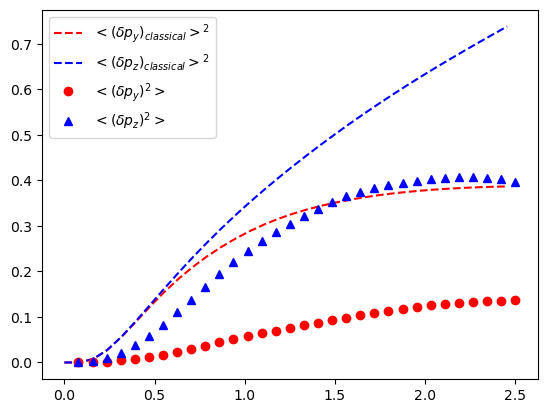

In [13]:
plt.plot(xp, piy, 'r--', label=r'$<(\delta p_y)_{classical}>^2$')
plt.plot(xp, piz, 'b--', label=r'$<(\delta p_z)_{classical}>^2$')

plt.plot(xplus[1:], pkin_y2_av, 'ro', label=r'$<(\delta p_y)^2>$')
plt.plot(xplus[1:], pkin_z2_av, 'b^', label=r'$<(\delta p_z)^2>$')

plt.legend()

### Another way to do it

In [1]:
# We create a list with the files to read

Nevs = 100; Nc = 3

file_list = [['/lustre/HQCD/carlos.lamas/qJetLFH_vQM/output/sub_A0_v2/result_{%i}_OUTPUT_VGlasma_nophase_R_q_g_1.000_WF_Init_q_Gaussian_nPx0_nPy0_wx_10.000000_wy_10.000000_cQ_%i_hQ_1_mq0_0.100_mq_0.100_mg_0.150_Lperp_2_Nperp_64_Leta_2.500000_Neta_1_Lmin_10.00_Kmax_2_g2mu_0.000_onMPIrank_0_step_32/PIperp/evolution_Piperp_sq_exp_autonomy.dat' %(nev, nc) for nev in range(Nevs)] for nc in range(1, Nc+1)]

In [2]:
# We convert to an array of DataFrames

import pandas as pd 
import numpy as np

df_list = []

for i in range(Nevs):
    df = [pd.read_table(file_list[c][i], header = None) for c in range(Nc)]
    df_list.append(df)

data = np.array(df_list)

print(np.shape(data))

(100, 3, 33, 9)


In [3]:
# Extract the results

xplus = data[0, 0, :, 0]

py2 = data[:, :, :, 5]
pz2 = data[:, :, :, 1]

Ay2 = data[:, :, :, 6]
Az2 = data[:, :, :, 2]

pyAy = data[:, :, :, 7]
pzAz = data[:, :, :, 3]

In [4]:
py2_av = np.average(py2, axis=(0, 1))
pz2_av = np.average(pz2, axis=(0, 1))

py2_av -= py2_av[0]
pz2_av -= pz2_av[0]

pyAy_av = np.average(pyAy, axis=(0, 1))
pzAz_av = np.average(pzAz, axis=(0, 1))

Ay2_av = np.average(Ay2, axis=(0, 1))
Az2_av = np.average(Az2, axis=(0, 1))

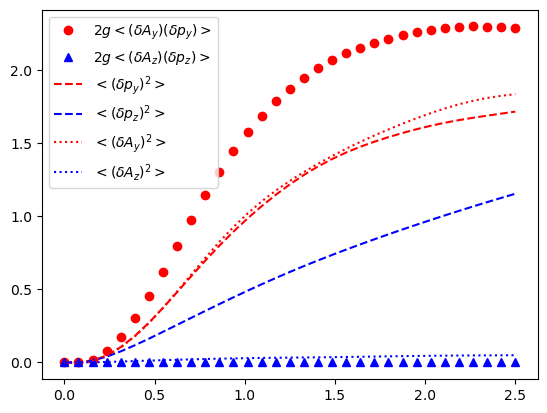

In [6]:
# Plot the different components

import matplotlib.pyplot as plt
plt.plot(xplus, pyAy_av, 'ro', label=r'$2g<(\delta A_y)(\delta p_y)>$')
plt.plot(xplus, pzAz_av, 'b^', label=r'$2g<(\delta A_z)(\delta p_z)>$')
plt.plot(xplus, py2_av, 'r--', label=r'$<(\delta p_y)^2>$')
plt.plot(xplus, pz2_av, 'b--', label=r'$<(\delta p_z)^2>$')
plt.plot(xplus, Ay2_av, 'r:', label=r'$<(\delta A_y)^2>$')
plt.plot(xplus, Az2_av, 'b:', label=r'$<(\delta A_z)^2>$')
plt.legend()


In [7]:
# Compute kinetic momentum

pkin_y2 = py2_av + Ay2_av - pyAy_av
pkin_z2 = pz2_av + Az2_av - pzAz_av

In [8]:
# Import classical results

xp = np.loadtxt('GoodResults_data/classical_pi.txt')[0]
piy = np.loadtxt('GoodResults_data/classical_pi.txt')[1]
piz = np.loadtxt('GoodResults_data/classical_pi.txt')[2]

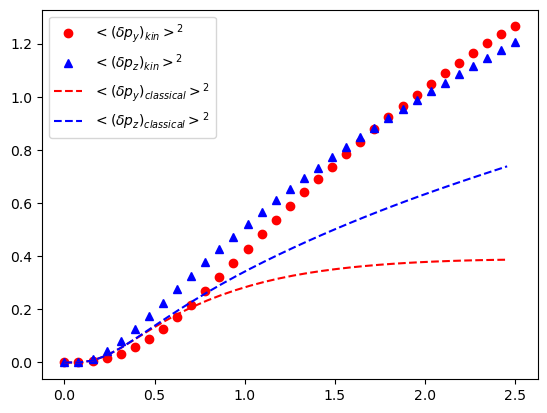

In [9]:
plt.plot(xplus, pkin_y2, 'ro', label=r'$<(\delta p_y)_{kin}>^2$')
plt.plot(xplus, pkin_z2, 'b^', label=r'$<(\delta p_z)_{kin}>^2$')

plt.plot(xp, piy, 'r--', label=r'$<(\delta p_y)_{classical}>^2$')
plt.plot(xp, piz, 'b--', label=r'$<(\delta p_z)_{classical}>^2$')

plt.legend()

### All from simulation

Import the data

In [2]:
# We create a list with the files to read

Nevs = 100; Nc = 3

file_list = [['/lustre/HQCD/carlos.lamas/qJetLFH_vQM/output/delta_A_results/result_{%i}_OUTPUT_VGlasma_nophase_R_q_g_1.000_WF_Init_q_Gaussian_nPx0_nPy0_wx_10.000000_wy_10.000000_cQ_%i_hQ_1_mq0_0.100_mq_0.100_mg_0.150_Lperp_2_Nperp_64_Leta_2.500000_Neta_1_Lmin_10.00_Kmax_2_g2mu_0.000_onMPIrank_0_step_32/PIperp/evolution_Piperp_sq_exp_autonomy.dat' %(nev, nc) for nev in range(Nevs)] for nc in range(1, Nc+1)]

In [3]:
# We convert to an array of DataFrames

import pandas as pd 
import numpy as np

df_list = []

for i in range(Nevs):
    df = [pd.read_table(file_list[c][i], header = None) for c in range(Nc)]
    df_list.append(df)

data = np.array(df_list)

print(np.shape(data))

(100, 3, 33, 9)


In [5]:
data_av = np.average(data, axis=(0, 1))

Compute kinetic momentum

In [7]:
py2 = data_av[:, 5]
pz2 = data_av[:, 1]

py2 -= py2[0]
pz2 -= pz2[0]

Ay2 = data_av[:, 6]
Az2 = data_av[:, 2]

pyAy = data_av[:, 7]
pzAz = data_av[:, 3]

pkin_y2 = py2 + Ay2 - pyAy
pkin_z2 = pz2 + Az2 - pzAz

In [ ]:
# # Average over color and configurations

# pkin_y2_av = np.average(pkin_y2, axis=(0, 1))
# pkin_z2_av = np.average(pkin_z2, axis=(0, 1))

Plot the results

In [10]:
# Import classical results

xp = np.loadtxt('GoodResults_data/classical_pi.txt')[0]
piy = np.loadtxt('GoodResults_data/classical_pi.txt')[1]
piz = np.loadtxt('GoodResults_data/classical_pi.txt')[2]

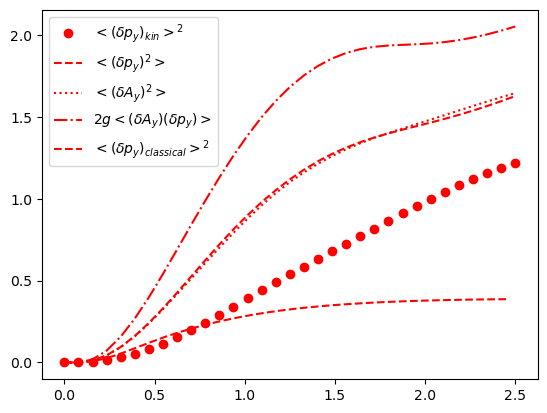

In [12]:
import matplotlib.pyplot as plt

plt.plot(xplus, pkin_y2, 'ro', label=r'$<(\delta p_y)_{kin}>^2$')
# plt.plot(xplus, pkin_z2, 'b^', label=r'$<(\delta p_z)_{kin}>^2$')

plt.plot(xplus, py2, 'r--', label=r'$<(\delta p_y)^2>$')
# plt.plot(xplus, pz2, 'b--', label=r'$<(\delta p_z)^2>$')

plt.plot(xplus, Ay2, 'r:', label=r'$<(\delta A_y)^2>$')
# plt.plot(xplus, Az2, 'b:', label=r'$<(\delta A_z)^2>$')

plt.plot(xplus, pyAy, 'r-.', label=r'$2g<(\delta A_y)(\delta p_y)>$')
# plt.plot(xplus, pzAz, 'b-.', label=r'$2g<(\delta A_z)(\delta p_z)>$')

plt.plot(xp, piy, 'r--', label=r'$<(\delta p_y)_{classical}>^2$')
# plt.plot(xp, piz, 'b--', label=r'$<(\delta p_z)_{classical}>^2$')

plt.legend()

plt.savefig('GoodResults_data/KineticMomentum.png', bbox_inches='tight')